<a href="https://colab.research.google.com/github/aschnapp/SurvITE_Reproduce/blob/main/SurvITE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-survival
!pip install tf_slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import random


def f_get_minibatch(mb_size, x1, x2=None, x3=None, x4=None, x5=None):
    idx = range(np.shape(x1)[0])
    idx = random.sample(idx, mb_size)
    
    if x2 is None:
        return x1[idx].astype(float)
    if x3 is None:
        return x1[idx].astype(float), x2[idx].astype(float)
    if x4 is None:
        return x1[idx].astype(float), x2[idx].astype(float), x3[idx].astype(float)
    if x5 is None:
        return x1[idx].astype(float), x2[idx].astype(float), x3[idx].astype(float), x4[idx].astype(float)
    
    return x1[idx].astype(float), x2[idx].astype(float), x3[idx].astype(float), x4[idx].astype(float), x5[idx].astype(float)

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np

_EPSILON = 1e-08


################################
##### USER-DEFINED FUNCTIONS
def log(x):
    return tf.log(x + _EPSILON)

def div(x, y):
    return tf.compat.v1.div(x, (y + _EPSILON))

################################
##### IPM TERMS
def pdist2sq(X,Y):
    """ Computes the squared Euclidean distance between all pairs x in X, y in Y """
    C = -2*tf.matmul(X,tf.transpose(Y))
    nx = tf.compat.v1.reduce_sum(tf.square(X),1,keep_dims=True)
    ny = tf.compat.v1.reduce_sum(tf.square(Y),1,keep_dims=True)
    D = (C + tf.transpose(ny)) + nx
    return D


# def mmd2_lin(X1,X2,p=0.5):
#     ''' Linear MMD '''
#     mean1 = tf.reduce_mean(X1,reduction_indices=0)
#     mean2 = tf.reduce_mean(X2,reduction_indices=0)

#     mmd = tf.compat.v1.reduce_sum(tf.square(2.0*p*mean1 - 2.0*(1.0-p)*mean2))

#     return mmd

# def mmd2_rbf(X1,X2,p=0.5,sig=0.1):
#     """ Computes the l2-RBF MMD for X1 vs X2 """
#     K11 = tf.exp(-pdist2sq(X1,X1)/tf.square(sig))
#     K12 = tf.exp(-pdist2sq(X1,X2)/tf.square(sig))
#     K22 = tf.exp(-pdist2sq(X2,X2)/tf.square(sig))

#     m = tf.compat.v1.to_float(tf.shape(X1)[0])
#     n = tf.compat.v1.to_float(tf.shape(X2)[0])

#     mmd = tf.square(1.0-p)/(m*(m-1.0))*(tf.compat.v1.reduce_sum(K11)-m)
#     mmd = mmd + tf.square(p)/(n*(n-1.0))*(tf.compat.v1.reduce_sum(K22)-n)
#     mmd = mmd - 2.0*p*(1.0-p)/(m*n)*tf.compat.v1.reduce_sum(K12)
#     mmd = 4.0*mmd

#     return mmd

def mmd2_lin(X1,X2,W1=None,W2=None,p=0.5,weights=None):
    ''' Linear MMD '''    
    if (W1 is None) and (W2 is None):
        W1 = tf.ones_like(X1[:,0])
        W2 = tf.ones_like(X2[:,0])
    
    W1     = div(W1, tf.compat.v1.reduce_sum(W1))
    W2     = div(W2, tf.compat.v1.reduce_sum(W2))
    
    W1     = tf.reshape(W1, [-1,1])
    W2     = tf.reshape(W2, [-1,1])
        
    mean1 = tf.compat.v1.reduce_sum(W1*X1, axis=0)
    mean2 = tf.compat.v1.reduce_sum(W2*X2, axis=0)
    
    mmd = tf.compat.v1.reduce_sum(tf.square(2.0*p*mean1 - 2.0*(1.0-p)*mean2))
    
    return mmd


def wasserstein(X1,X2,W1=None,W2=None,p=0.5,lam=10,its=10): #,sq=False,backpropT=False):
    """ Returns the Wasserstein distance between treatment groups """    
    n1 = tf.compat.v1.to_float(tf.shape(X1)[0])
    n2 = tf.compat.v1.to_float(tf.shape(X2)[0])
    
    ''' Compute distance matrix'''
    M = pdist2sq(X1,X2)
        
    #for now consider W1 and W2 is [None,] shape
    if (W1 is None) and (W2 is None):
        W1 = tf.ones_like(X1[:,0])
        W2 = tf.ones_like(X2[:,0])
    
    W1     = div(W1, tf.compat.v1.reduce_sum(W1))
    W2     = div(W2, tf.compat.v1.reduce_sum(W2))
    
    W1     = tf.reshape(W1, [-1,1])
    W2     = tf.reshape(W2, [-1,1])
    W_mask = tf.tile(W1, [1, n2]) * tf.tile(tf.transpose(W2), [n1, 1])
    
    ''' Estimate lambda and delta '''
    M_mean = tf.compat.v1.reduce_sum(M*W_mask) #this becomes weighted average
    
    M_drop  = tf.nn.dropout(M, 10/(n1*n2))
    delta   = tf.stop_gradient(tf.reduce_max(M))
    eff_lam = tf.stop_gradient(lam/M_mean)

    ''' Compute new distance matrix '''
    Mt  = M
    row = delta*tf.ones(tf.shape(M[0:1,:]))
    col = tf.concat([delta*tf.ones(tf.shape(M[:,0:1])),tf.zeros((1,1))], axis=0)
    Mt  = tf.concat([M,row], axis=0)
    Mt  = tf.concat([Mt,col], axis=1)

    ''' Compute marginal vectors '''        
    a = tf.concat([p*tf.ones_like(X1[:,0:1])*W1, (1-p)*tf.ones((1,1))], axis=0)
    b = tf.concat([(1-p)*tf.ones_like(X2[:,0:1])*W2, p*tf.ones((1,1))], axis=0)

    ''' Compute kernel matrix'''
    Mlam = eff_lam*Mt
    K = tf.exp(-Mlam) + 1e-6 # added constant to avoid nan
    U = K*Mt
    ainvK = K/a

    u = a
    for i in range(0,its):
        u = 1.0/(tf.matmul(ainvK,(b/tf.transpose(tf.matmul(tf.transpose(u),K)))))
    v = b/(tf.transpose(tf.matmul(tf.transpose(u),K)))

    T = u*(tf.transpose(v)*K)

    E = T*Mt
    D = 2*tf.compat.v1.reduce_sum(E)

    return D #, Mlam

In [ ]:
import tensorflow as tf
import numpy as np
import tf_slim as slim

_EPSILON = 1e-08

################################
##### USER-DEFINED FUNCTIONS
def log(x):
    return tf.log(x + _EPSILON)

def div(x, y):
    return tf.compat.v1.div(x, (y + _EPSILON))


##### NETWORK FUNCTIONS
# removed reuse=tf.AUTO_REUSE
def fcnet(x_, o_dim_, o_fn_, num_layers_=1, h_dim_=100, activation_fn=tf.nn.relu, keep_prob_=1.0, w_reg_=None, name='fcnet'):
    '''
        x_            : (2D-tensor) input
        o_dim_        : (int) output dimension
        o_type_       : (string) output type one of {'continuous', 'categorical', 'binary'}
        num_layers_   : (int) # of hidden layers
        activation_fn_: tf activation functions
        reuse         : (bool) 
    '''
    with tf.compat.v1.variable_scope(name):
        if num_layers_ == 1:
            out =  slim.layers.fully_connected(inputs=x_, num_outputs=o_dim_, activation_fn=o_fn_, weights_regularizer=w_reg_, scope='layer_out')
        else:
            for tmp_layer in range(num_layers_-1):
                if tmp_layer == 0:
                    net = x_
                net = slim.layers.fully_connected(inputs=net, num_outputs=h_dim_, activation_fn=activation_fn, weights_regularizer=w_reg_, scope='layer_'+str(tmp_layer))
                net = tf.compat.v1.nn.dropout(net, keep_prob=keep_prob_)
            out =  slim.layers.fully_connected(inputs=net, num_outputs=o_dim_, activation_fn=o_fn_, weights_regularizer=w_reg_, scope='layer_out')  
    return out


################################
##### NETWORK 
class SurvITE:
    def __init__(self, sess, name, input_dims, network_settings):
        self.sess               = sess
        self.name               = name

        ### INPUT DIMENSIONS
        self.x_dim              = input_dims['x_dim']
        self.t_max              = input_dims['t_max']
        self.num_Event          = input_dims['num_Event'] #Without counting censoring.
        

        ### NETWORK HYPER-PARMETERS
        self.z_dim              = network_settings['z_dim']  #PHI(X)
        
        self.h_dim1             = network_settings['h_dim1']  #PHI
        self.h_dim2             = network_settings['h_dim2']  #Hypothesis
        
        self.num_layers1        = network_settings['num_layers1']
        self.num_layers2        = network_settings['num_layers2']
 
        self.active_fn          = network_settings['active_fn']
        self.reg_scale          = network_settings['reg_scale']
        
        self.ipm_term           = network_settings['ipm_term']
        self.is_treat           = network_settings['is_treat'] #boolean
        self.is_smoothing       = network_settings['is_smoothing'] #boolean
        
        assert self.ipm_term in ['mmd_lin', 'wasserstein', 'no_ipm']

        self.clipping_thres     = 10.

        
        self._build_net()


    def _build_net(self):
        with tf.compat.v1.variable_scope(self.name):
            #### PLACEHOLDER DECLARATION
            self.lr_rate        = tf.compat.v1.placeholder(tf.float32, [], name='learning_rate')
            self.k_prob         = tf.compat.v1.placeholder(tf.float32, [], name='keep_probability')   #keeping rate
            self.alpha          = tf.compat.v1.placeholder(tf.float32, [], name='alpha')
            self.beta           = tf.compat.v1.placeholder(tf.float32, [], name='beta')
            self.gamma          = tf.compat.v1.placeholder(tf.float32, [], name='gamma')

            self.x              = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x_dim], name='inputs')
            self.y              = tf.compat.v1.placeholder(tf.float32, shape=[None, self.num_Event], name='labels')   #event/censoring label (censoring: the last column)
            self.t              = tf.compat.v1.placeholder(tf.float32, shape=[None, 1], name='times')
            self.a              = tf.compat.v1.placeholder(tf.float32, shape=[None, 1], name='treatment_assignments')
            self.w              = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t_max, 2], name='weights')            
            
            self.is_training    = tf.compat.v1.placeholder(tf.bool, name = 'train_test_indicator') #for batch_normalization
            
            self.mb_size        = tf.shape(self.x)[0]
            
            ### mask generation -- for easier computation for at-risk patients
            tmp_range      = tf.cast(tf.expand_dims(tf.range(0, self.t_max, 1), axis=0), tf.float32)
            self.mask1     = tf.cast(tf.equal(tmp_range, self.t), tf.float32)
            self.mask2     = tf.cast(tf.less_equal(tmp_range, self.t), tf.float32)

            y_expanded     = self.mask1 * self.y
            
            
            #PHI(x)
            self.z              = fcnet(
                x_=self.x, o_dim_=self.z_dim, o_fn_=None, 
                num_layers_=self.num_layers1, h_dim_=self.h_dim1, activation_fn=self.active_fn, 
                keep_prob_=self.k_prob, name='encoder'
            )
            
            
            ###BATCH NORMALIZATION. (This follows the implementation of CFRNet)
#             self.z = tf.math.l2_normalize(self.z, axis=0)
            self.z = tf.compat.v1.layers.batch_normalization(self.z, training=self.is_training)
            self.z = self.active_fn(self.z)
            self.z = tf.compat.v1.nn.dropout(self.z, keep_prob=self.k_prob)


            ### H(Z; A,T)
            for m in range(self.t_max):
                tmp_A1              = fcnet(
                    x_=self.z, o_dim_=1, o_fn_=None, 
                    num_layers_=self.num_layers2, h_dim_=self.h_dim2, activation_fn=self.active_fn, 
                    keep_prob_=self.k_prob, name='hypothesis_A1_T{}'.format(m)
                )
                
                if self.is_treat:
                    tmp_A0              = fcnet(
                        x_=self.z, o_dim_=1, o_fn_=None, 
                        num_layers_=self.num_layers2, h_dim_=self.h_dim2, activation_fn=self.active_fn, 
                        keep_prob_=self.k_prob, name='hypothesis_A0_T{}'.format(m)
                    )
                else:
                    tmp_A0              = tf.zeros_like(tmp_A1)
                    
                if m == 0:
                    self.logits_A1 = tmp_A1
                    self.logits_A0 = tmp_A0
                else:
                    self.logits_A1 = tf.concat([self.logits_A1, tmp_A1], axis=1)
                    self.logits_A0 = tf.concat([self.logits_A0, tmp_A0], axis=1)
                    
            
            ### loss - IPM regularization
            self.loss_IPM1 = 0. #treated
            self.loss_IPM0 = 0. #not-treated

            self.w_clipped = tf.clip_by_value(self.w, 0., self.clipping_thres, name='weights_clipped')

            if self.ipm_term != 'no_ipm':
                # for m in range(1, self.t_max):
                for m in range(0, self.t_max):
                    idx1             = tf.where(tf.equal(self.a[:, 0]*self.mask2[:, m], 1.))[:,0]
                     
                    if self.is_treat:
                        idx0             = tf.where(tf.equal((1.-self.a[:, 0])*self.mask2[:, m], 1.))[:,0]
                    
                    
                    if self.ipm_term == 'mmd_lin':
                        self.loss_IPM1 += tf.cond(tf.equal(tf.size(idx1), 0),
                                                  lambda: tf.constant(0, tf.float32),
                                                  lambda: mmd2_lin(self.z, 
                                                                   tf.gather(self.z, idx1, axis=0), 
                                                                   tf.ones_like(self.z[:,0]), 
                                                                   tf.gather(self.w_clipped[:, m, 0], idx1, axis=0))
                                                 )
                        if self.is_treat:
                            self.loss_IPM0 += tf.cond(tf.equal(tf.size(idx0), 0),
                                                      lambda: tf.constant(0, tf.float32),
                                                      lambda: mmd2_lin(self.z, 
                                                                          tf.gather(self.z, idx0, axis=0), 
                                                                          tf.ones_like(self.z[:,0]), 
                                                                          tf.gather(self.w_clipped[:, m, 1], idx0, axis=0))
                                                     )
                        
                    elif self.ipm_term == 'wasserstein':
                        self.loss_IPM1 += tf.cond(tf.equal(tf.size(idx1), 0),
                                                  lambda: tf.constant(0, tf.float32),
                                                  lambda: wasserstein(self.z, 
                                                                      tf.gather(self.z, idx1, axis=0), 
                                                                      tf.ones_like(self.z[:,0]), 
                                                                      tf.gather(self.w_clipped[:, m, 0], idx1, axis=0))
                                                 )
                        if self.is_treat:
                            self.loss_IPM0 += tf.cond(tf.equal(tf.size(idx0), 0),
                                                      lambda: tf.constant(0, tf.float32),
                                                      lambda: wasserstein(self.z, 
                                                                          tf.gather(self.z, idx0, axis=0), 
                                                                          tf.ones_like(self.z[:,0]), 
                                                                          tf.gather(self.w_clipped[:, m, 1], idx0, axis=0))
                                                     )
            self.loss_IPM = self.loss_IPM1 + self.loss_IPM0



            ### loss - smoothing regularization
            self.loss_smoothing_A1 = 0. #treated
            self.loss_smoothing_A0 = 0. #not-treated


            if self.is_smoothing:
                for m in range(1, self.t_max):
                    tmp_Wprev = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope=self.name+'/hypothesis_A1_T{}'.format(m-1))[::2]
                    tmp_Wcurr = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope=self.name+'/hypothesis_A1_T{}'.format(m))[::2]
                    for l in range(self.num_layers2):
                        self.loss_smoothing_A1 += tf.reduce_mean((tmp_Wprev[l] - tmp_Wcurr[l])**2) ## average over each parameter (for scaling)
                    
                    if self.is_treat:
                        tmp_Wprev = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope=self.name+'/hypothesis_A0_T{}'.format(m-1))[::2]
                        tmp_Wcurr = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope=self.name+'/hypothesis_A0_T{}'.format(m))[::2]
                        for l in range(self.num_layers2):
                            self.loss_smoothing_A0 += tf.reduce_mean((tmp_Wprev[l] - tmp_Wcurr[l])**2) ## average over each parameter (for scaling)
            
            self.loss_smoothing = self.loss_smoothing_A1 + self.loss_smoothing_A0             
                    
            tmp_w1 = div(self.w[:, :, 0], tf.reduce_sum(self.mask2 * self.a * self.w[:, :, 0], axis=0, keepdims=True) )
            tmp_w1 = self.mask2 * self.a * tmp_w1
            
            if self.is_treat:
                tmp_w0 = div(self.w[:, :, 1], tf.reduce_sum(self.mask2 * (1.- self.a) * self.w[:, :, 1], axis=0, keepdims=True) )
                tmp_w0 = self.mask2 * (1. - self.a) * tmp_w0
                            
            ### loss - factual loss
            self.loss      = 0
            loss_A1        = tf.reduce_sum(
                tmp_w1 * self.mask2 * self.a * tf.nn.sigmoid_cross_entropy_with_logits(labels=y_expanded, logits=self.logits_A1)
            )
            self.loss     += loss_A1
            if self.is_treat:
                loss_A0        = tf.reduce_sum(
                    tmp_w0 * self.mask2 * (1.- self.a) * tf.nn.sigmoid_cross_entropy_with_logits(labels=y_expanded, logits=self.logits_A0)
                )            
                self.loss     += loss_A0            
                   
            ### l2-regularization    
            self.vars_encoder = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope=self.name+'/encoder')
            
            if self.reg_scale != 0:
                vars_reg          = [w for w in self.vars_encoder if 'weights' in w.name]
                regularizer       = slim.layers.l2_regularizer(scale=self.reg_scale, scope=None)
                loss_reg          = slim.layers.apply_regularization(regularizer, vars_reg)   
            else:
                loss_reg          = 0.


            self.solver       = tf.compat.v1.train.AdamOptimizer(learning_rate=self.lr_rate).minimize(self.loss)
            
            self.loss_total   = self.loss + self.beta * self.loss_IPM + self.gamma * self.loss_smoothing + loss_reg
            self.solver_total = tf.compat.v1.train.AdamOptimizer(learning_rate=self.lr_rate).minimize(self.loss_total)
            
            
            ### batch-normalization operation
            self.extra_update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS) 
                      
                    

    def predict_hazard_A1(self, x_):
        odd    = tf.exp(self.logits_A1)
        hazard = odd / (1. + odd)
        return self.sess.run(hazard, feed_dict={self.x:x_, self.k_prob:1.0, self.is_training: False})
         
    def predict_hazard_A0(self, x_):
        odd    = tf.exp(self.logits_A0)
        hazard = odd / (1. + odd)
        return self.sess.run(hazard, feed_dict={self.x:x_, self.k_prob:1.0, self.is_training: False})
    
    def predict_survival_A1(self, x_):
        hazard         = self.predict_hazard_A1(x_)  
        surv           = np.ones_like(hazard)
#         surv[:, 1:]    = np.cumprod(1. - hazard, axis=1)[:, :-1]
        surv[:, :]    = np.cumprod(1. - hazard, axis=1)
        return surv
    
    def predict_survival_A0(self, x_):
        hazard         = self.predict_hazard_A0(x_)  
        surv           = np.ones_like(hazard)
#         surv[:, 1:]    = np.cumprod(1. - hazard, axis=1)[:, :-1]
        surv[:, :]    = np.cumprod(1. - hazard, axis=1)
        return surv
        
        
    def train_baseline(self, x_, y_, t_, a_, lr_train_=1e-3, k_prob_=1.0):
        return self.sess.run([self.solver, self.extra_update_ops, self.loss],
                             feed_dict={self.x:x_, self.y:y_, self.t:t_, self.a:a_, self.w:np.ones([np.shape(x_)[0], self.t_max, 2]),
                                        self.lr_rate:lr_train_, 
                                        self.k_prob:k_prob_,
                                        self.is_training: True})

    def get_loss_basline(self, x_, y_, t_, a_, k_prob_=1.0):
        return self.sess.run(self.loss,
                             feed_dict={self.x:x_, self.y:y_, self.t:t_, self.a:a_, self.w:np.ones([np.shape(x_)[0], self.t_max, 2]),
                                        self.k_prob:k_prob_,
                                        self.is_training: False})
    
    
    def train(self, x_, y_, t_, a_, w_, beta_=1e-3, gamma_=1e-3, lr_train_=1e-3, k_prob_=1.0):
        if not self.is_smoothing:
            gamma_ = 0.
        return self.sess.run([self.solver_total, self.extra_update_ops, self.loss_total, self.loss, self.loss_IPM],
                             feed_dict={self.x:x_, self.y:y_, self.t:t_, self.a:a_, self.w:w_,
                                        self.beta:beta_, self.gamma:gamma_,
                                        self.lr_rate:lr_train_, 
                                        self.k_prob:k_prob_,
                                        self.is_training: True})

    def get_loss(self, x_, y_, t_, a_, w_, beta_=1e-3, gamma_=1e-3, k_prob_=1.0):
        if not self.is_smoothing:
            gamma_ = 0.
        return self.sess.run([self.loss_total, self.loss, self.loss_IPM],
                             feed_dict={self.x:x_, self.y:y_, self.t:t_, self.a:a_, self.w:w_,
                                        self.beta:beta_, self.gamma:gamma_,
                                        self.k_prob:k_prob_,
                                        self.is_training: False})
    
    

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import tensorflow as tf
import random
import matplotlib.pyplot as plt

from sksurv.metrics import concordance_index_ipcw

import time

from sklearn.model_selection import train_test_split

import os

In [ ]:
ipm_type      = 'wasserstein'

weight        = False
is_smoothing  = False
is_treat      = True

is_training   = True#True

OUT_ITERATION = 5
N_tr = 5000
N_te = 5000

if not weight:
    weight_type = 'noweight'
else:
    weight_type  = '' 


if ipm_type == 'no_ipm':
    beta       = 0.
else:
    beta   = 1e-3 #1e-3

    
if is_smoothing:
    gamma  = 1e-3
else:
    gamma  = 0.


lr_rate   = 1e-3
mb_size   = 512

keep_prob = 0.7

seed           = 1234

TMAX           = 30
eval_times     = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]


# results_mse_hzrd1 = np.zeros([OUT_ITERATION, TMAX+1])
# results_mse_hzrd0 = np.zeros([OUT_ITERATION, TMAX+1])

# results_mse_surv1 = np.zeros([OUT_ITERATION, TMAX+1])
# results_mse_surv0 = np.zeros([OUT_ITERATION, TMAX+1])

# results_hte_hzrd   = np.zeros([OUT_ITERATION, TMAX+1])
# results_hte_surv   = np.zeros([OUT_ITERATION, TMAX+1])

# results1 = np.zeros([OUT_ITERATION, len(eval_times)])
# results2 = np.zeros([OUT_ITERATION, len(eval_times)])
# results3 = np.zeros([OUT_ITERATION, len(eval_times)])

In [ ]:
seed         = 1234
modelname    = 'SurvITE'

# Import Observational Dataset

In [ ]:
# download data
import requests
import io

# response = requests.get('https://raw.githubusercontent.com/chl8856/survITE/d7f217fb2bc2406ec11656be49c4fc29156372fb/data/tr_data.npz')
# response.raise_for_status()
# npz = np.load(io.BytesIO(response.content))
# tr_x = npz['x']
# tr_a = npz['a']
# tr_t = npz['t']
# tr_y = npz['y']

# response_te = requests.get('https://raw.githubusercontent.com/chl8856/survITE/d7f217fb2bc2406ec11656be49c4fc29156372fb/data/te_data.npz')
# response_te.raise_for_status()
# npz = np.load(io.BytesIO(response_te.content))
# te_x = npz['x']
# te_a = npz['a']
# te_t = npz['t']
# te_y = npz['y']


In [ ]:
# npz  = np.load('./data/tr_data.npz')
# tr_x = npz['x']
# tr_a = npz['a']
# tr_t = npz['t']
# tr_y = npz['y']

# npz  = np.load('./data/te_data.npz')
# te_x = npz['x']
# te_a = npz['a']
# te_t = npz['t']
# te_y = npz['y']

tr_y_structured = [(tr_y[i], tr_t[i]) for i in range(len(tr_y))]
tr_y_structured = np.array(tr_y_structured, dtype=[('status', 'bool'),('time','<f8')])

te_y_structured = [(te_y[i], te_t[i]) for i in range(len(te_y))]
te_y_structured = np.array(te_y_structured, dtype=[('status', 'bool'),('time','<f8')])

TMAX           = 30
eval_times     = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]


results_mse_hzrd1 = np.zeros([1, TMAX+1])
results_mse_hzrd0 = np.zeros([1, TMAX+1])

results_mse_surv1 = np.zeros([1, TMAX+1])
results_mse_surv0 = np.zeros([1, TMAX+1])

results_hte_hzrd   = np.zeros([1, TMAX+1])
results_hte_surv   = np.zeros([1, TMAX+1])

results1 = np.zeros([1, len(eval_times)])
results2 = np.zeros([1, len(eval_times)])
results3 = np.zeros([1, len(eval_times)])

# Training

In [ ]:
num_Event   = 1

z_dim       = 100
x_dim       = np.shape(tr_x)[1]

num_layers1  = 3
h_dim1       = 100

num_layers2  = 2
h_dim2       = 100


input_dims = {
    'x_dim': x_dim,
    'num_Event': num_Event,
    't_max': TMAX+1
}
network_settings = {
    'z_dim': z_dim,     

    # Phi()
    'h_dim1': h_dim1, 
    'num_layers1': num_layers1, 

    # Hypothesis()
    'h_dim2': h_dim2, 
    'num_layers2': num_layers2,

    'active_fn': tf.nn.elu,
    'reg_scale': 0.,
    'ipm_term' : ipm_type, 
    'is_treat' : is_treat,
    'is_smoothing': is_smoothing
}


tf.compat.v1.reset_default_graph()

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

model = SurvITE(sess, 'SurvITE', input_dims, network_settings)
sess.run(tf.compat.v1.global_variables_initializer())

saver       = tf.compat.v1.train.Saver()

savepath = './{}/surviTE/'.format(modelname)

if not os.path.exists(savepath):
    os.makedirs(savepath)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [ ]:
if not is_treat:
    tr_a = np.ones_like(tr_t)
    te_a = np.ones_like(te_t)

from sklearn.model_selection import train_test_split

tr_y = tr_y.reshape([-1,1])
tr_t = tr_t.reshape([-1,1])
tr_a = tr_a.reshape([-1,1])

if is_treat:
    tr_w  = np.ones([np.shape(tr_x)[0], TMAX+1, 2])
else:
    tr_w  = np.ones([np.shape(tr_x)[0], TMAX+1, 1])

tr_x_,va_x, tr_y_,va_y, tr_t_,va_t, tr_a_,va_a, tr_w_,va_w = train_test_split(tr_x, tr_y, tr_t, tr_a, tr_w, test_size=0.2, random_state=seed)

In [ ]:
iterations = 20000

avg_tr_loss_total = 0.
avg_tr_loss       = 0.
avg_tr_loss_ipm   = 0.

avg_va_loss_total = 0.
avg_va_loss       = 0.
avg_va_loss_ipm   = 0.

check_step        = 100

min_loss          = 1e+8
max_flag          = 20
stop_flag         = 0

if is_training:
    for itr in range(iterations):    
        if beta == 0.:
            x_mb, y_mb, t_mb, a_mb = f_get_minibatch(mb_size, tr_x_, tr_y_, tr_t_, tr_a_)    
            _, _, tmp_tr_loss          = model.train_baseline(x_mb, y_mb, t_mb, a_mb, lr_train_=lr_rate, k_prob_=keep_prob)
            avg_tr_loss_total         += tmp_tr_loss/check_step
            avg_tr_loss               += tmp_tr_loss/check_step

            x_mb, y_mb, t_mb, a_mb = f_get_minibatch(min(mb_size, np.shape(va_x)[0]), va_x, va_y, va_t, va_a)    
            tmp_va_loss                = model.get_loss_basline(x_mb, y_mb, t_mb, a_mb, k_prob_=keep_prob)
            avg_va_loss_total         += tmp_va_loss/check_step
            avg_va_loss               += tmp_va_loss/check_step

        else:
            x_mb, y_mb, t_mb, a_mb, w_mb = f_get_minibatch(mb_size, tr_x_, tr_y_, tr_t_, tr_a_, tr_w_)
            _, _, tmp_tr_loss_total, tmp_tr_loss, tmp_tr_loss_ipm = model.train(x_mb, y_mb, t_mb, a_mb, w_mb, 
                                                                                beta_=beta, gamma_=gamma, 
                                                                                lr_train_=lr_rate, k_prob_=keep_prob)
            avg_tr_loss_total         += tmp_tr_loss_total/check_step
            avg_tr_loss               += tmp_tr_loss/check_step
            avg_tr_loss_ipm           += tmp_tr_loss_ipm/check_step

            x_mb, y_mb, t_mb, a_mb, w_mb = f_get_minibatch(min(mb_size, np.shape(va_x)[0]), va_x, va_y, va_t, va_a, va_w)    
            tmp_va_loss_total, tmp_va_loss, tmp_va_loss_ipm      = model.get_loss(x_mb, y_mb, t_mb, a_mb, w_mb, 
                                                                                  beta_=beta, gamma_=gamma, 
                                                                                  k_prob_=1.0)
            avg_va_loss_total         += tmp_va_loss_total/check_step
            avg_va_loss               += tmp_va_loss/check_step
            avg_va_loss_ipm           += tmp_va_loss_ipm/check_step

        if (itr + 1)%check_step == 0:
            stop_flag += 1

            print(
                "ITR {:04d}  | TR: loss_T={:.3f} loss_S={:.3f} loss_IPM={:.3f} | loss_T={:.3f} loss_S={:.3f} loss_IPM={:.3f}".format(
                itr+1, avg_tr_loss_total, avg_tr_loss, avg_tr_loss_ipm, avg_va_loss_total, avg_va_loss, avg_va_loss_ipm)
            )

            if min_loss > avg_va_loss_total:
                min_loss  = avg_va_loss_total
                stop_flag = 0

                saver.save(sess, savepath + 'model_{}{}'.format(ipm_type,weight_type))
                print('model saved...')

            else:
                if stop_flag >= max_flag:
                    break


            avg_tr_loss_total = 0.
            avg_tr_loss = 0.
            avg_tr_loss_ipm = 0.

            avg_va_loss_total = 0.
            avg_va_loss = 0.
            avg_va_loss_ipm = 0.

ITR 0100  | TR: loss_T=16.803 loss_S=11.133 loss_IPM=5669.748 | loss_T=13.322 loss_S=12.272 loss_IPM=1049.589
model saved...
ITR 0200  | TR: loss_T=10.604 loss_S=6.535 loss_IPM=4069.369 | loss_T=7.701 loss_S=6.180 loss_IPM=1520.900
model saved...
ITR 0300  | TR: loss_T=9.485 loss_S=6.304 loss_IPM=3180.778 | loss_T=7.334 loss_S=6.068 loss_IPM=1265.741
model saved...
ITR 0400  | TR: loss_T=8.650 loss_S=6.039 loss_IPM=2610.747 | loss_T=6.828 loss_S=5.893 loss_IPM=934.666
model saved...
ITR 0500  | TR: loss_T=8.130 loss_S=5.927 loss_IPM=2203.163 | loss_T=6.490 loss_S=5.767 loss_IPM=723.283
model saved...
ITR 0600  | TR: loss_T=7.671 loss_S=5.806 loss_IPM=1865.266 | loss_T=6.285 loss_S=5.706 loss_IPM=579.676
model saved...
ITR 0700  | TR: loss_T=7.261 loss_S=5.700 loss_IPM=1560.274 | loss_T=6.145 loss_S=5.677 loss_IPM=468.467
model saved...
ITR 0800  | TR: loss_T=6.930 loss_S=5.631 loss_IPM=1298.259 | loss_T=6.054 loss_S=5.674 loss_IPM=380.043
model saved...
ITR 0900  | TR: loss_T=6.664 los

# Testing

In [ ]:
# call this if restoring data
!rm -rf SurvITE
!unzip SurvITE.zip

unzip:  cannot find or open SurvITE.zip, SurvITE.zip.zip or SurvITE.zip.ZIP.


In [ ]:
saver.restore(sess, savepath + 'model_{}{}'.format(ipm_type,weight_type))

In [ ]:
surv1 = model.predict_survival_A1(te_x)
surv0 = model.predict_survival_A0(te_x)

hzrd1 = model.predict_hazard_A1(te_x)
hzrd0 = model.predict_hazard_A0(te_x)

hzrd = np.zeros_like(hzrd1)
if is_treat:
    hzrd[te_a == 0, :] = hzrd0[te_a == 0, :]
hzrd[te_a == 1, :] = hzrd1[te_a == 1, :]

surv = np.zeros_like(surv1)
if is_treat:
    surv[te_a == 0, :] = surv0[te_a == 0, :]
surv[te_a == 1, :] = surv1[te_a == 1, :]

In [ ]:
tr_data = np.load("S_1_train_new.npz")
te_data = np.load("S_1_test_new.npz")

te_hazs = te_data['haz']


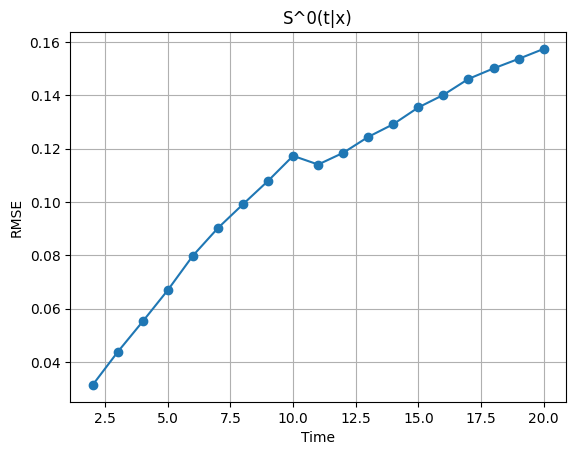

In [ ]:

def survival(haz):
  surv = []
  for patient in haz:
    surv_patient = np.cumprod(1-patient)
    surv.append(surv_patient)
  
  return np.array(surv)

def RMSE(surv_hat, surv):
  rmse = []
  
  for time_point in range(len(surv[0])):
    diff = 0
    for patient in range(len(surv_hat)):
      diff += (surv[patient, time_point] - surv_hat[patient, time_point])**2
    diff = diff / len(surv_hat)
    rmse.append(np.sqrt(diff))

  return rmse

rmse_data = RMSE(surv0, survival(te_hazs))

fig, ax = plt.subplots()
ax.plot(np.arange(2, 21), rmse_data[2:21], '-o')
ax.set_title("S^0(t|x)")
ax.set_xlabel('Time')
ax.set_ylabel('RMSE')
ax.grid()
plt.show()



In [ ]:
def RMSE(surv_hat, surv):
  rmse = []
  for time_point in range(len(surv[0])):
    diff = 0
    for patient in range(len(surv_hat)):
      diff += (surv[patient, time_point] - surv_hat[patient, time_point])**2
    diff = diff / len(surv_hat)
    rmse.append(np.sqrt(diff))

  return rmse

rmse_data = RMSE(surv0, te_hazs)

In [ ]:
surv

In [ ]:
!zip -r ./SurvITE.zip ./SurvITE/

  adding: SurvITE/ (stored 0%)
  adding: SurvITE/surviTE/ (stored 0%)
  adding: SurvITE/surviTE/model_wassersteinnoweight.index (deflated 77%)
  adding: SurvITE/surviTE/model_wassersteinnoweight.meta (deflated 92%)
  adding: SurvITE/surviTE/model_wassersteinnoweight.data-00000-of-00001 (deflated 62%)
  adding: SurvITE/surviTE/checkpoint (deflated 44%)


In [ ]:
from google.colab import files
files.download("SurvITE.zip")